In [503]:
import numpy as np
import numba as nb 
from consav.linear_interp import interp_1d_vec
from EconModel import jit
from HANCModel import HANCModelClass
import matplotlib.pyplot as plt
from consav.grids import equilogspace
from consav.markov import log_rouwenhorst

These notes are inspired by and draw upon the lecture notes of Matthew Rognlie, (available at this [link](https://github.com/shade-econ/nber-workshop-2023/tree/main)) which served as the original reference. I gratefully acknowledge his work and contribution as the foundation for this material.

# Solving for the stationary equilibrium in the HANC model

This notebook explains how to solve for the stationary equilibrium in the HANC model without the use of the GEModelTools. 

First, let us create a class that contains the necessary parameters to solve the model. 

In [504]:
class Parameters:
    def __init__(self):
        # preferences
        self.beta = 0.975
        self.sigma = 1.0
        
        # production
        self.alpha = 0.36
        self.delta = 0.1
        self.Gamma = 1.0
        
        # grids
        self.Na = 500
        self.a_min = 0.0
        self.a_max = 10_000.0 
        self.a_grid = equilogspace(self.a_min,self.a_max,self.Na)

        # income
        self.rho_z = 0.95
        self.sigma_psi = 0.30*(1.0-self.rho_z**2.0)**0.5
        self.Nz = 7
        self.z_grid, self.z_trans,self.z_ergodic,_,_ = log_rouwenhorst(self.rho_z,self.sigma_psi,self.Nz)
        

par = Parameters()

# 1. Obtain the policy function with EGM

The first step is to use the endogenous-grid method (EGM) to obtain the policy function for savings and consumption. 

The `solve_hh_backwards_one_step` implements one step of the EGM algorithm: given a guess on `vbeg_a`, the derivative of the value function, it returns policies for `a, c` and updates `vbeg_a`.

Lets's go in the detail about the EGM algorithm. Our goal is to obtain the policy functions $a'(a,z)$ and $c(a,z)$ for each point on the grids `a_grid` and `z_grid`. The standard method to do this if VFI: guess a value function $V(a,z)$, and iterate over the RHS of the Bellman equation $V^n(a,z)=(\max_{a'}\{u(c)+\beta \mathbb{E}[V^{n-1}(a',z')]\} until $V^n(a,z)\approx V^{n-1}(a,z)$. The issue with this method is that for each point $(a,z)$ on our grids, we need to run an optimization algorithm (like the golden-search algorithm), which is costly. 

The endogenous grid-method of Caroll proposes to iterate over the Euler equation insteady. First, recall that the first-order condition of the problem writes $u'(c)=\beta W'(a',z)$ where $W(a',z)=\mathbb{E}_z[V(a',z')]$. Our first step is thus to define an initial guess for $V_a$. 

In [505]:
w = 1 
r = 0.05 
y = w*par.z_grid
c = r*par.a_grid[np.newaxis,:] + y[:,np.newaxis]  # implied guess on a'(a,z)=a
Va = (1+r)*c**(-par.sigma)
Wa = par.z_trans @ Va # Take expectation using matrix multiplication

Instead of fixing a grid over $a$, we now set a grid over $a'$. We can set use the FOC to obtain $c$ as a function of $a'$:
$c(a',z)=u'^{-1}[\beta W'(a',z)]$. 

In [506]:
Nz, Na = Wa.shape
a = np.zeros((Nz, Na))
c = np.zeros((Nz, Na)) 

# a. solve step
for i_z in range(Nz):
    ## i. get c(a',z)
    c_endo = (par.beta*Wa[i_z])**(-1/par.sigma)


We also know that, from the budget constraint, we must have
$$a'+c(a',z)=a(1+r)+wz=m.$$

Since we know $a'$ (defined on our grid), this mean that we have $a'(m,z)$ (where m is the cash-on-hands). $m$ here is an 'endogenous grid', hence the name of the method. To obtain $a'(m,z)$ defined on an exogenous grid $m$, we interpolate the function $a'$ defined on `m_endo` over an exogenous grid `m`: this gives us `a'(m,z)`. 

In [507]:
for i_z in range(Nz):
    # ii. compute m_endo = c(a',z) + a'
    m_endo = c_endo + par.a_grid # current consumption + end-of-period assets
    
    # iii. interpolation to fixed grid
    m = (1+r)*par.a_grid + w*par.z_grid[i_z] # exogenous grid of coh
    interp_1d_vec(m_endo,par.a_grid,m,a[i_z]) # fill up the array a[i_z]

The last thing to note is that, due to the borrowing constraint, some points $a'(a,z)$ implied by the FOC are not feasible and violate the borrowing constraint. We just impose them by setting $a'(a,z)=0$. 

In [508]:
for i_z in range(Nz):
    a[i_z,:] = np.fmax(a[i_z,:],0.0) # enforce borrowing constraint

We then can compute $c(a,z)$ easily, and use the envelope condition to update our guess on the derivative of the value function
$$Va^n=(1+r)c(a,z)^{-\sigma}$$
and compute the expectation using the Markov transition matrix.

In [509]:
for i_z in range(Nz):
    c[i_z] = m-a[i_z]
RHS = (1+r)*c**(-par.sigma)
vbeg_a_new = par.z_trans @ RHS

We then put all of this in one function, and iterate until convergence.

In [510]:
def solve_hh_backwards_one_step(z_trans, z_grid, a_grid, sigma, beta, r, w, vbeg_a):

    Nz, Na = vbeg_a.shape
    a = np.zeros((Nz, Na))
    c = np.zeros((Nz, Na)) 
    
    # a. solve step
    for i_z in range(Nz):
    
        ## i. get c(a',z)
        c_endo = (beta*vbeg_a[i_z])**(-1/sigma)
        
        # ii. compute m_endo = c(a',z) + a'
        m_endo = c_endo + a_grid # current consumption + end-of-period assets
        
        # iii. interpolation to fixed grid
        m = (1+r)*a_grid + w*z_grid[i_z] # exogenous grid of coh
        interp_1d_vec(m_endo,a_grid,m,a[i_z]) # fill up the array a[i_z]
        a[i_z,:] = np.fmax(a[i_z,:],0.0) # enforce borrowing constraint
        c[i_z] = m-a[i_z]

    # b. expectation step
    RHS = (1+r)*c**(-sigma)
    vbeg_a_new = z_trans @ RHS

    return c, a, vbeg_a_new


Then, for a given $r$, $w$, we can loop over this step until convergence, that is, until the `vbeg_a` we feed into the function is arbitrarily close to the `vbeg_a_new` that it outputs.

In [511]:
w = 1.0
r = 0.01

In [512]:
def egm_ss(r, w, par, max_iter = 10_000, tol = 1e-8, verbose = False):
    """ solve the EGM for the steady state """

    # a. initialize
    y = w*par.z_grid
    c = r*par.a_grid[np.newaxis,:] + y[:,np.newaxis] 
    Va = (1+r)*c**(-par.sigma)

    # b. iterate
    for it in range(max_iter):

        # i. solve backwards
        c, a, Va_new = solve_hh_backwards_one_step(par.z_trans, par.z_grid, par.a_grid, par.sigma, par.beta, r, w, Va)

        # ii. check convergence
        error = np.max(np.abs(Va - Va_new))
        if verbose:
            print(error)
        if error < tol:
            break

        Va = Va_new.copy()

    return c, a, Va_new

c, a, Va = egm_ss(r, w, par)


That's it! We have obtains the policy functions for consumption and savings of the households at the steady state for a given $r$ and $w$ (i.e. in partial equilibrium). We can plot those for given $(a,z)$. 

As expected, the consumption function is a concave function of wealth, and the net-savings function is a decreasing function of wealth, crossing the 0 horizontal line (implying a buffer-stock behavior).

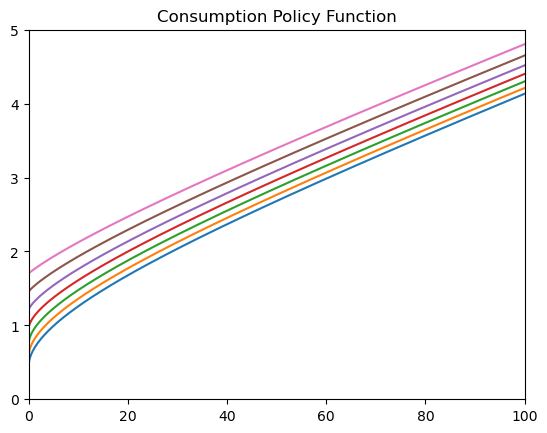

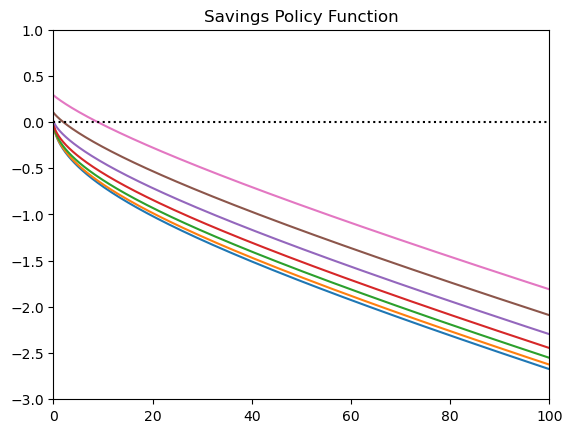

In [513]:
plt.plot(par.a_grid, c.T)
plt.xlim(0, 100)
plt.ylim(0, 5)
plt.title('Consumption Policy Function')
plt.show()

plt.plot(par.a_grid, (a-par.a_grid[np.newaxis,:]).T)
plt.plot(par.a_grid, np.zeros_like(par.a_grid), linestyle = ':', color = 'black')
plt.xlim(0, 100)
plt.ylim(-3, 1)
plt.title('Savings Policy Function')
plt.show()

We can also compute MPCs by looking at how consumption increase at the steady state when agents have one additional unit of cash-on-hand.

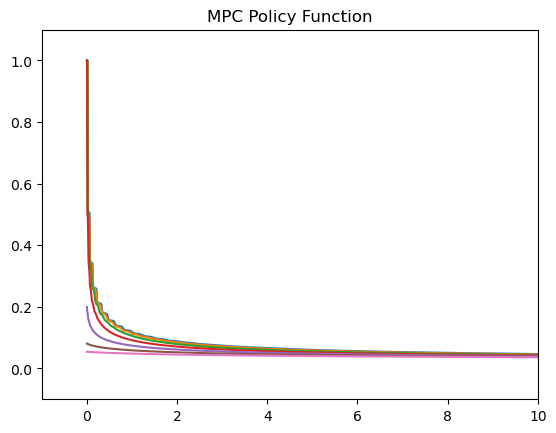

In [514]:
def calc_MPC(par,c):
    
    MPC = np.zeros(c.shape)
    dc = (c[:,1:]-c[:,:-1])
    dm = (1+r)*par.a_grid[np.newaxis,1:]-(1+r)*par.a_grid[np.newaxis,:-1]
    MPC[:,:-1] = dc/dm
    MPC[:,-1] = MPC[:,-1] # assuming constant MPC at end
    return MPC

MPC = calc_MPC(par,c)

plt.plot(par.a_grid, MPC.T)
plt.xlim(-1, 10)
plt.ylim(-0.1, 1.1)
plt.title('MPC Policy Function')
plt.show()

MPCs are high for low-wealth and low-productivity households, but quickly converge to the PIH benchmark as wealth increases.

# 2. Obtain the distribution using the histogram method

The second part of this course is to compute the distribution. Our goal is to simulate the households in the economy in order to compute the distribution and the relevant aggregage variables. 

A first method to do this is the Monte-Carlo method: simulate $N$ households with initial conditions $(a_0,z_0)$ for $T$ periods using the policy functions and drawing shocks for each period. Because of the law of large number, if $T$ is large enough, the distribution will converge to its stationary distribution. However, this method is quite slow because for each $(i,t)$, we need to interpolate over the policy function and draw some new shocks for $z'$. It will also require a large $N$ for the law of large number to kick in.

Instead, we may use the histogram method (also sometimes called Young's method). The idea is to approximate a distribution $D(a,z)$ over our existing grids `a_grid`, `z_grid`. 

In [515]:
D = np.zeros((Nz, Na))
D[0] = 1.0 # initialize all households to be a z = z_min, a = a_min

One difficulty is that our policy function $a'(a,z)$ implies decisions that are most likely not on the grid for `a_grid`. For example, `a'[5,0]` is located between the points 16 and 17.

In [516]:
a_i = np.searchsorted(par.a_grid, a[5,0], side='right') -1

print(a[5,0])
print(par.a_grid[a_i])
print(par.a_grid[a_i+1])

0.10234185176274312
0.10115705538363684
0.10869389538481028


To solve this problem, we will discretize our policy function, and use the 'lottery method' to distribute households to the points surrounding $a'(a,z)$. First, we obtain all the indexes on our grid such that, for all $a'(a,z)$, we find `a_i` where `a_grid[a_i]` is the point on the grid just below `a'` and `a_grid[a_i+1]` is the point just above. We can do this quickly using the `searchsorted` function from numpy.

In [517]:
a_i = np.searchsorted(par.a_grid, a, side='right') -1

print(a[5,0])
print(par.a_grid[a_i[5,0]])
print(par.a_grid[a_i[5,0]+1])

0.10234185176274312
0.10115705538363684
0.10869389538481028


We will distribute households in this way:
`a_pi = (a_grid[a_i+1] - a)/(a_grid[a_i+1] - a_grid[a_i])`
if `a=a_grid[a_i]` we put a mass one on `a_grid[a_i]`. If `a=a_grid[a_i+1]`, we put a mass one on `a_grid[a_i+1]`. Otherwise, we put more weight on the point on the grid closer to $a'(a,z)$. 

In [518]:
a_pi = (par.a_grid[a_i+1] - a[5,0])/(par.a_grid[a_i+1] - par.a_grid[a_i])

We then write the `get_lottery` function that performs this discretization for all points on the grids.

In [519]:
def get_lottery(a, a_grid):
    # step 1: find the i such that a' lies between gridpoints a_i and a_(i+1)
    a_i = np.searchsorted(a_grid, a, side='right') - 1
    a_i = np.clip(a_i, 0, len(a_grid)-2)

    # step 2: implement (8) to obtain lottery probabilities pi
    a_pi = (a_grid[a_i+1] - a)/(a_grid[a_i+1] - a_grid[a_i])
    
    return a_i, a_pi


We can now iterate over our discretize policy to compute the distribution next period, when we iterate once over the policy function.

In [520]:
@nb.njit
def forward_policy(D, a_i, a_pi):
    Dend = np.zeros_like(D)
    for e in range(a_i.shape[0]):
        for a in range(a_i.shape[1]):
            # send pi(e,a) of the mass to gridpoint i(e,a)
            Dend[e, a_i[e,a]] += a_pi[e,a]*D[e,a]
            
            # send 1-pi(e,a) of the mass to gridpoint i(e,a)+1
            Dend[e, a_i[e,a]+1] += (1-a_pi[e,a])*D[e,a]
            
    return Dend

To account for the idiosyncratic shock, we apply the transpose of our Markov matrix to the distribution.

In [521]:
def forward_iteration(D, z_trans, a_i, a_pi):
    Dend = forward_policy(D, a_i, a_pi)    
    return z_trans.T @ Dend

What does this do, in practice?

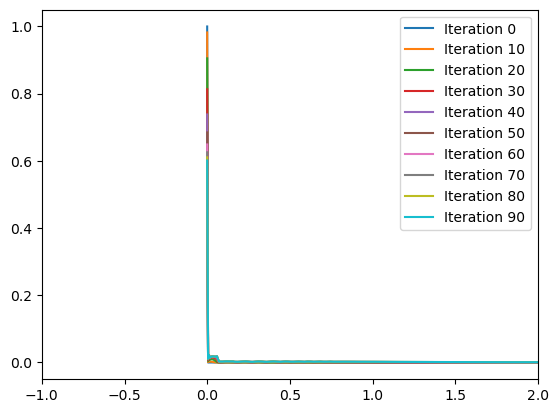

In [522]:
a_i, a_pi = get_lottery(a, par.a_grid)

D = np.zeros((Nz, Na))
D[0,0] = 1.0
for i in range(100):
    D_new = forward_iteration(D, par.z_trans, a_i, a_pi)
    if i%10==0:
        plt.plot(par.a_grid, np.sum(D_new, axis=0), label=f'Iteration {i}')
        plt.xlim(-1, 2)
        plt.legend()
    D = D_new

We then iterate over this mapping until convergence!

In [523]:
def distribution_ss(a, par, tol=1E-10):
    a_i, a_pi = get_lottery(a, par.a_grid)

    # as initial D, use stationary distribution for s, plus uniform over a
    D = par.z_ergodic[:, np.newaxis] * np.ones_like(par.a_grid) / len(par.a_grid)

    # now iterate until convergence to acceptable threshold
    for _ in range(100_000):
        D_new = forward_iteration(D, par.z_trans, a_i, a_pi)
        if np.max(np.abs(D_new - D)) < tol:
            return D_new
        D = D_new

In [524]:
D = distribution_ss(a, par)

One very important thing to understand is that, also the *distribution* is stationary, households move within this distribution at every period. However, because of the law of large numbers, each move perfectly compensate each other so that the distribution remain the same.

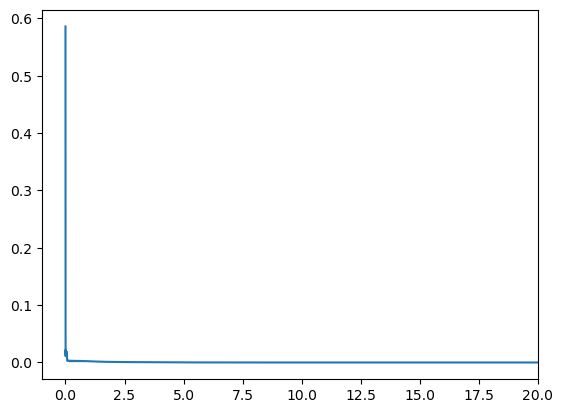

In [525]:
D_flat = np.sum(D, axis = 0)
plt.plot(par.a_grid, D_flat)
plt.xlim(-1, 20)
plt.show()

The last step is then to compute aggregate variables. We can do this easily by simply by integrating the policy functions over the distribution (i.e. summing, in our discrete world)

In [526]:
A = np.sum(a*D)
C = np.sum(c*D)

And that's it! We have seen how to:
1. Compute the policy functions of the households for a given $(r,w)$ 
2. And to compute the associated stationary distribution.
3. How to compute the aggregate variables of the household block

# 3. Obtain aggregate hh variables using policies and the distribution

In [527]:
def household_ss(r, w, par, max_iter = 10_000, tol = 1e-8, verbose = False):
    c, a, Va = egm_ss(r, w, par, max_iter, tol, verbose) 
    D = distribution_ss(a, par)
    A = np.sum(D * a)
    C = np.sum(D * c) 
    return A, C, D, a, c, Va 


In [528]:
def firm(K, Gamma, par): 
    r = par.alpha * Gamma * K**(par.alpha-1) - par.delta
    Y = Gamma * K**par.alpha 
    w = (1-par.alpha) * Y  
    return r, w, Y

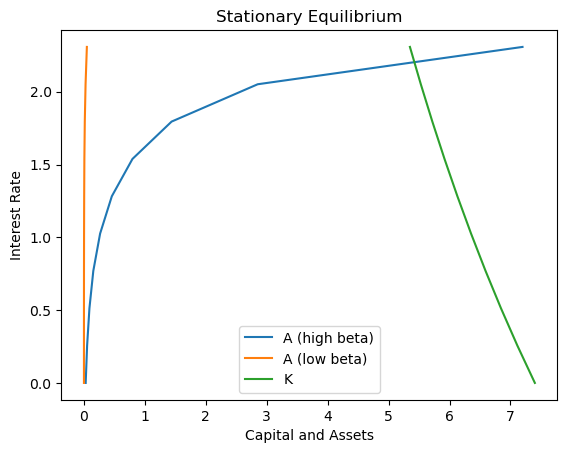

In [529]:
def asset_supply_r(r_vec, beta):
    par.beta = beta 
    Nr = len(r_vec)
    K = ((r_vec+par.delta) / (par.alpha * par.Gamma))**(1/(par.alpha-1))
    Y = par.Gamma * K**par.alpha
    w_vec = (1-par.alpha) * Y
    A_vec = np.zeros(Nr)
    for i, r in enumerate(r_vec):
        print
        A_vec[i], _, _, _, _, _  = household_ss(r_vec[i], w_vec[i], par) 
    return A_vec, K_vec

Nr = 10
r_vec = np.linspace(0.0, (1/par.beta-1)*0.9, Nr)
A_vec, K_vec = asset_supply_r(r_vec, par.beta)
A_vec_2, _ = asset_supply_r(r_vec , par.beta * 0.98)
plt.plot(A_vec, r_vec * 100, label = 'A (high beta)')
plt.plot(A_vec_2, r_vec * 100, label = "A (low beta)")
plt.plot(K_vec, r_vec * 100, label = 'K')
plt.xlabel('Capital and Assets')
plt.ylabel('Interest Rate')
plt.title('Stationary Equilibrium')
plt.legend()

In [530]:
1/par.beta -1

0.04657247514390361

# 3. Put everything together: solve for the steady-state in GE

In [543]:
par.beta = 0.95 
def find_ss(K, par):
    r, w, Y = firm(K, par.Gamma, par) 
    A, _, _, _, _, _  = household_ss(r, w, par) 
    print(A-K)
    return A-K

from scipy.optimize import brentq 

K = brentq(find_ss, 3.9, 4.0, args=(par,))


5.26020539587323
-0.5296175025982954
-0.2666076603510068
0.013947965261993378
-0.0006844488501944745
-1.677541281441819e-06
1.9954704555402714e-11
-1.3144152433142153e-11


## Calibrating the model 

A common calibration, at the annual level, is to set:
- $W/Y=4$
- $r=5%$ 
- $w/Y=1/3$ 
- normalize $Y=1$

Instead of searching the parameter value for $\beta$ that implies an $r=5\%$ and solving the model multiple times, we can use the $\beta$ to clear the asset market instead!

In [546]:
r = 0.05 
Y = 1 
K = 4 
par.alpha = 1/3 
par.Gamma = Y /(K**par.alpha)
par.delta = par.alpha * par.Gamma * K**(par.alpha-1) - r 
w = (1-par.alpha) * Y

In [547]:
def find_ss_beta(beta, par):
    par.beta = beta
    r = 0.05
    w = 1-par.alpha
    K = 4 
    A, _, _, _, _, _  = household_ss(r, w, par) 
    print(A-K)
    return A-K

from scipy.optimize import brentq 
beta = brentq(find_ss_beta, 0.9, 0.952, args=(par,))

-3.9999999999999987
18.850971301144178
-3.9999999999999964
-3.975423715491448
-3.690302699991704
-2.7649965573647464
-0.8924888421928925
1.3487170555343484
-0.21485529404579662
0.009983083845258811
-0.0004332611687845045
-8.180241333199945e-07
2.204991744747531e-11
-1.881705014028512e-09


In [ ]:
par.beta = beta 
A, C, D, a, c, Va = household_ss(r, w, par) 